## Music generation project - tokens prediction

In this project I try to generate music with 2 different neural network architectures. The idea was taken from [article](https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5) where we use *MIDI* audio format which can be parsed with a *music21* library in python. As a dataset I have used 9 violin pieces downloaded from *musescore* which gives more than 1.5 hours of audio data.

I have trained models in 3 different ways. After parsing with a *music21* library we get not only notes but also their duartions and offsets. Therefore we should also predict these parameters. I came up with 3 different models based on 2 architectures. The best option was to train a network with 3 inputs and 3 outputs at every time step where each of the outputs consists of probabilities of every unique value. I could not find a proper solution how to build such model so I have build 2 different models. Later on I managed to build this model which is the most accurate. All of the models are presented in 3 different notebooks and can be tested in the Streamlit app which is unfortunately not deployed cause I could not save the generated *midi* files. All necessary Streamlit app files are in the [github](https://github.com/twrzeszcz/music-generation-streamlit) repo. The first model was used to predict tokens which are concatenations of note, duration and offset. This limits the possible parameter values. The other option was to train 3 separate models for predicting notes, durations and offsets and then use them for parameters generation. The problem here is that we do not include information about e.g notes and durations in offsets predictions so the model will predict offsets based only on the past offsets and not notes and durations. In this notebook the token model is trained.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from music21 import *
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from fractions import Fraction
import pickle

%matplotlib inline

### Preprocessing

In [10]:
filepaths = glob.glob('data/*.mid')

In [11]:
filepaths

['data\\Bach_-_Sonata_No._1_in_G_minor_-_BWV_1001_-_Presto.mid',
 'data\\Concerto_in_A_minor_A_Vivaldi.mid',
 'data\\Fur_Elise.mid',
 'data\\Solo_Violin_Caprice_No._24_in_A_Minor_-_N._Paganini_Op._1_No._24.mid',
 'data\\Solo_Violin_Partita_No._2_in_D_Minor_-_J._S._Bach_BWV_1004.mid',
 'data\\Solo_Violin_Partita_No._3_in_E_Major_-_J._S._Bach_BWV_1006.mid',
 'data\\Solo_Violin_Sonata_No._1_in_G_Minor_-_J._S._Bach_BWV_1001.mid',
 'data\\Solo_Violin_Sonata_No._2_in_A_Minor_-_J._S._Bach_BWV_1003.mid',
 'data\\Spring-Four_seasons_vivaldi.mid']

To parse every audio file we have to split it to parts and iterate over them. Then we check if the element in part is a *note*, *chord* or a *rest* symbol. For note we append the *pitch*. For chords we have to concatenate notes which create a chord. Rest symbols are appended as 'rest'. Then for each of the paramters we also have a duration and offset which are concatenated to form a single string. Offsets are calculated as a difference between the offset for a current symbol and offset for the previous symbol.  

In [14]:
def read_parse_midi(file):
    midi = converter.parse(file)
    notes_to_parse = None
    tokens = []
    
    parts = instrument.partitionByInstrument(midi)

    for part in parts:
        if 'Violin' or 'StringInstrument' in str(part):
            notes_to_parse = part.recurse()
            for i in range(len(notes_to_parse)):
                if isinstance(notes_to_parse[i], note.Note):
                    tokens.append(str(notes_to_parse[i].pitch) + '_' 
                                  + str(notes_to_parse[i].duration.quarterLength) + '_'
                                  + str(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset)))
                elif isinstance(notes_to_parse[i], chord.Chord):
                    tokens.append('.'.join(str(n) for n in notes_to_parse[i].normalOrder) + '_' 
                                  + str(notes_to_parse[i].duration.quarterLength) + '_'
                                  + str(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset)))
                elif isinstance(notes_to_parse[i], note.Rest):
                    tokens.append(notes_to_parse[i].name + '_'
                                  + str(notes_to_parse[i].duration.quarterLength) + '_'
                                  + str(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset)))
    return np.array(tokens)

In [16]:
read_parse_midi(filepaths[4])[:10]

array(['D4_0.25_0', 'rest_22/3_0', 'rest_232.75_0', 'rest_1793/3_0',
       'D4_0.0_0', 'D4_0.75_0', 'E4_0.25_3/4', 'F4_0.25_1/4',
       'G4_0.25_1/4', 'A4_0.25_1/4'], dtype='<U17')

In [17]:
tokens_full = [read_parse_midi(file) for file in filepaths]

In [18]:
for i in tokens_full:
    print(i.shape)

(1604,)
(2005,)
(589,)
(1634,)
(8006,)
(5054,)
(3890,)
(5740,)
(1101,)


Then we have to get the list of unique tokens.

In [20]:
all_tokens = [element for tokens in tokens_full for element in tokens] 
unique_tokens = set(all_tokens)

In [21]:
len(unique_tokens)

1829

In [173]:
pickle.dump(unique_tokens, open('unique_tokens.pkl', 'wb'))

In [22]:
unique_tokens

{'9.0_0.5_1/2',
 'rest_89.0_0',
 '9.0_0.25_0',
 '3.7_0.25_1/2',
 '1.4.8_1.0_1',
 'B-4_0.25_3/4',
 '2.4_0.25_1/12',
 'A4_0.0_1/4',
 '6.11_2.0_0',
 'F#4_1.0_1/4',
 'E4_0.75_1/12',
 '9.11_0.25_1/6',
 'E-5_1.0_3/2',
 '0.2_0.5_1/4',
 'F#5_1/3_1/4',
 'G4_0.75_1/4',
 '3.6_1.0_1',
 'rest_41/12_1/12',
 '5.7_0.5_1/2',
 '9.1.4_1.5_0',
 'B4_3.0_1/6',
 'E6_1.0_1',
 'G#5_0.5_3/2',
 '6.9.1_1.0_1',
 '9.11_0.5_1/4',
 'rest_2.75_1/6',
 '9.1.4_2.0_0',
 '2.4.8_1.0_1',
 '9.2_1.0_1/12',
 'A4_1.0_0',
 '2.5_1.0_1/12',
 '2.4_1.0_1/2',
 'E4_0.25_5/4',
 '6.11_3.0_1',
 'C#5_0.5_0',
 'rest_0.25_1/4',
 '7.11_0.25_3/4',
 '3.4_0.25_1/12',
 '0.4.7_0.5_1/4',
 'A3_0.25_1/2',
 'E5_1/3_1/4',
 '4.5_0.5_1/2',
 '2.7_0.25_1/4',
 'D4_0.25_1/6',
 'A5_2.0_1/2',
 '10.0_0.25_1/2',
 '7.8_0.25_1/12',
 'rest_1.75_1/12',
 '2.6_1.5_1',
 '11.2.4.7_1.0_1',
 'rest_79.5_0',
 'C5_0.25_1/3',
 '8.0_2.0_1',
 'rest_269/12_1/6',
 'G#4_0.5_2',
 '8.0_0.5_1/2',
 'A6_0.25_0',
 'rest_1793/3_0',
 '7.10_1.0_1/2',
 '2.6_0.5_0',
 'rest_38/3_0',
 '9.11.2.

In [48]:
(pd.Series(all_tokens).value_counts() * 100 / len(all_tokens))[:20]

A4_0.25_1/4     4.783445
D5_0.25_1/4     4.209567
E5_0.25_1/4     4.027276
C5_0.25_1/4     3.672822
G4_0.25_1/4     2.852513
B4_0.25_1/4     2.417041
B-4_0.25_1/4    2.180738
A5_0.25_1/4     2.065962
F5_0.25_1/4     2.025453
E4_0.25_1/4     1.978193
E-5_0.25_1/4    1.978193
G5_0.25_1/4     1.944435
F4_0.25_1/4     1.910678
D4_0.25_1/4     1.816156
C#5_0.25_1/4    1.539344
F#4_0.25_1/4    1.417817
F#5_0.25_1/4    1.407690
G#5_0.25_1/4    1.174763
G#4_0.25_1/4    1.147757
B5_0.25_1/4     0.995848
dtype: float64

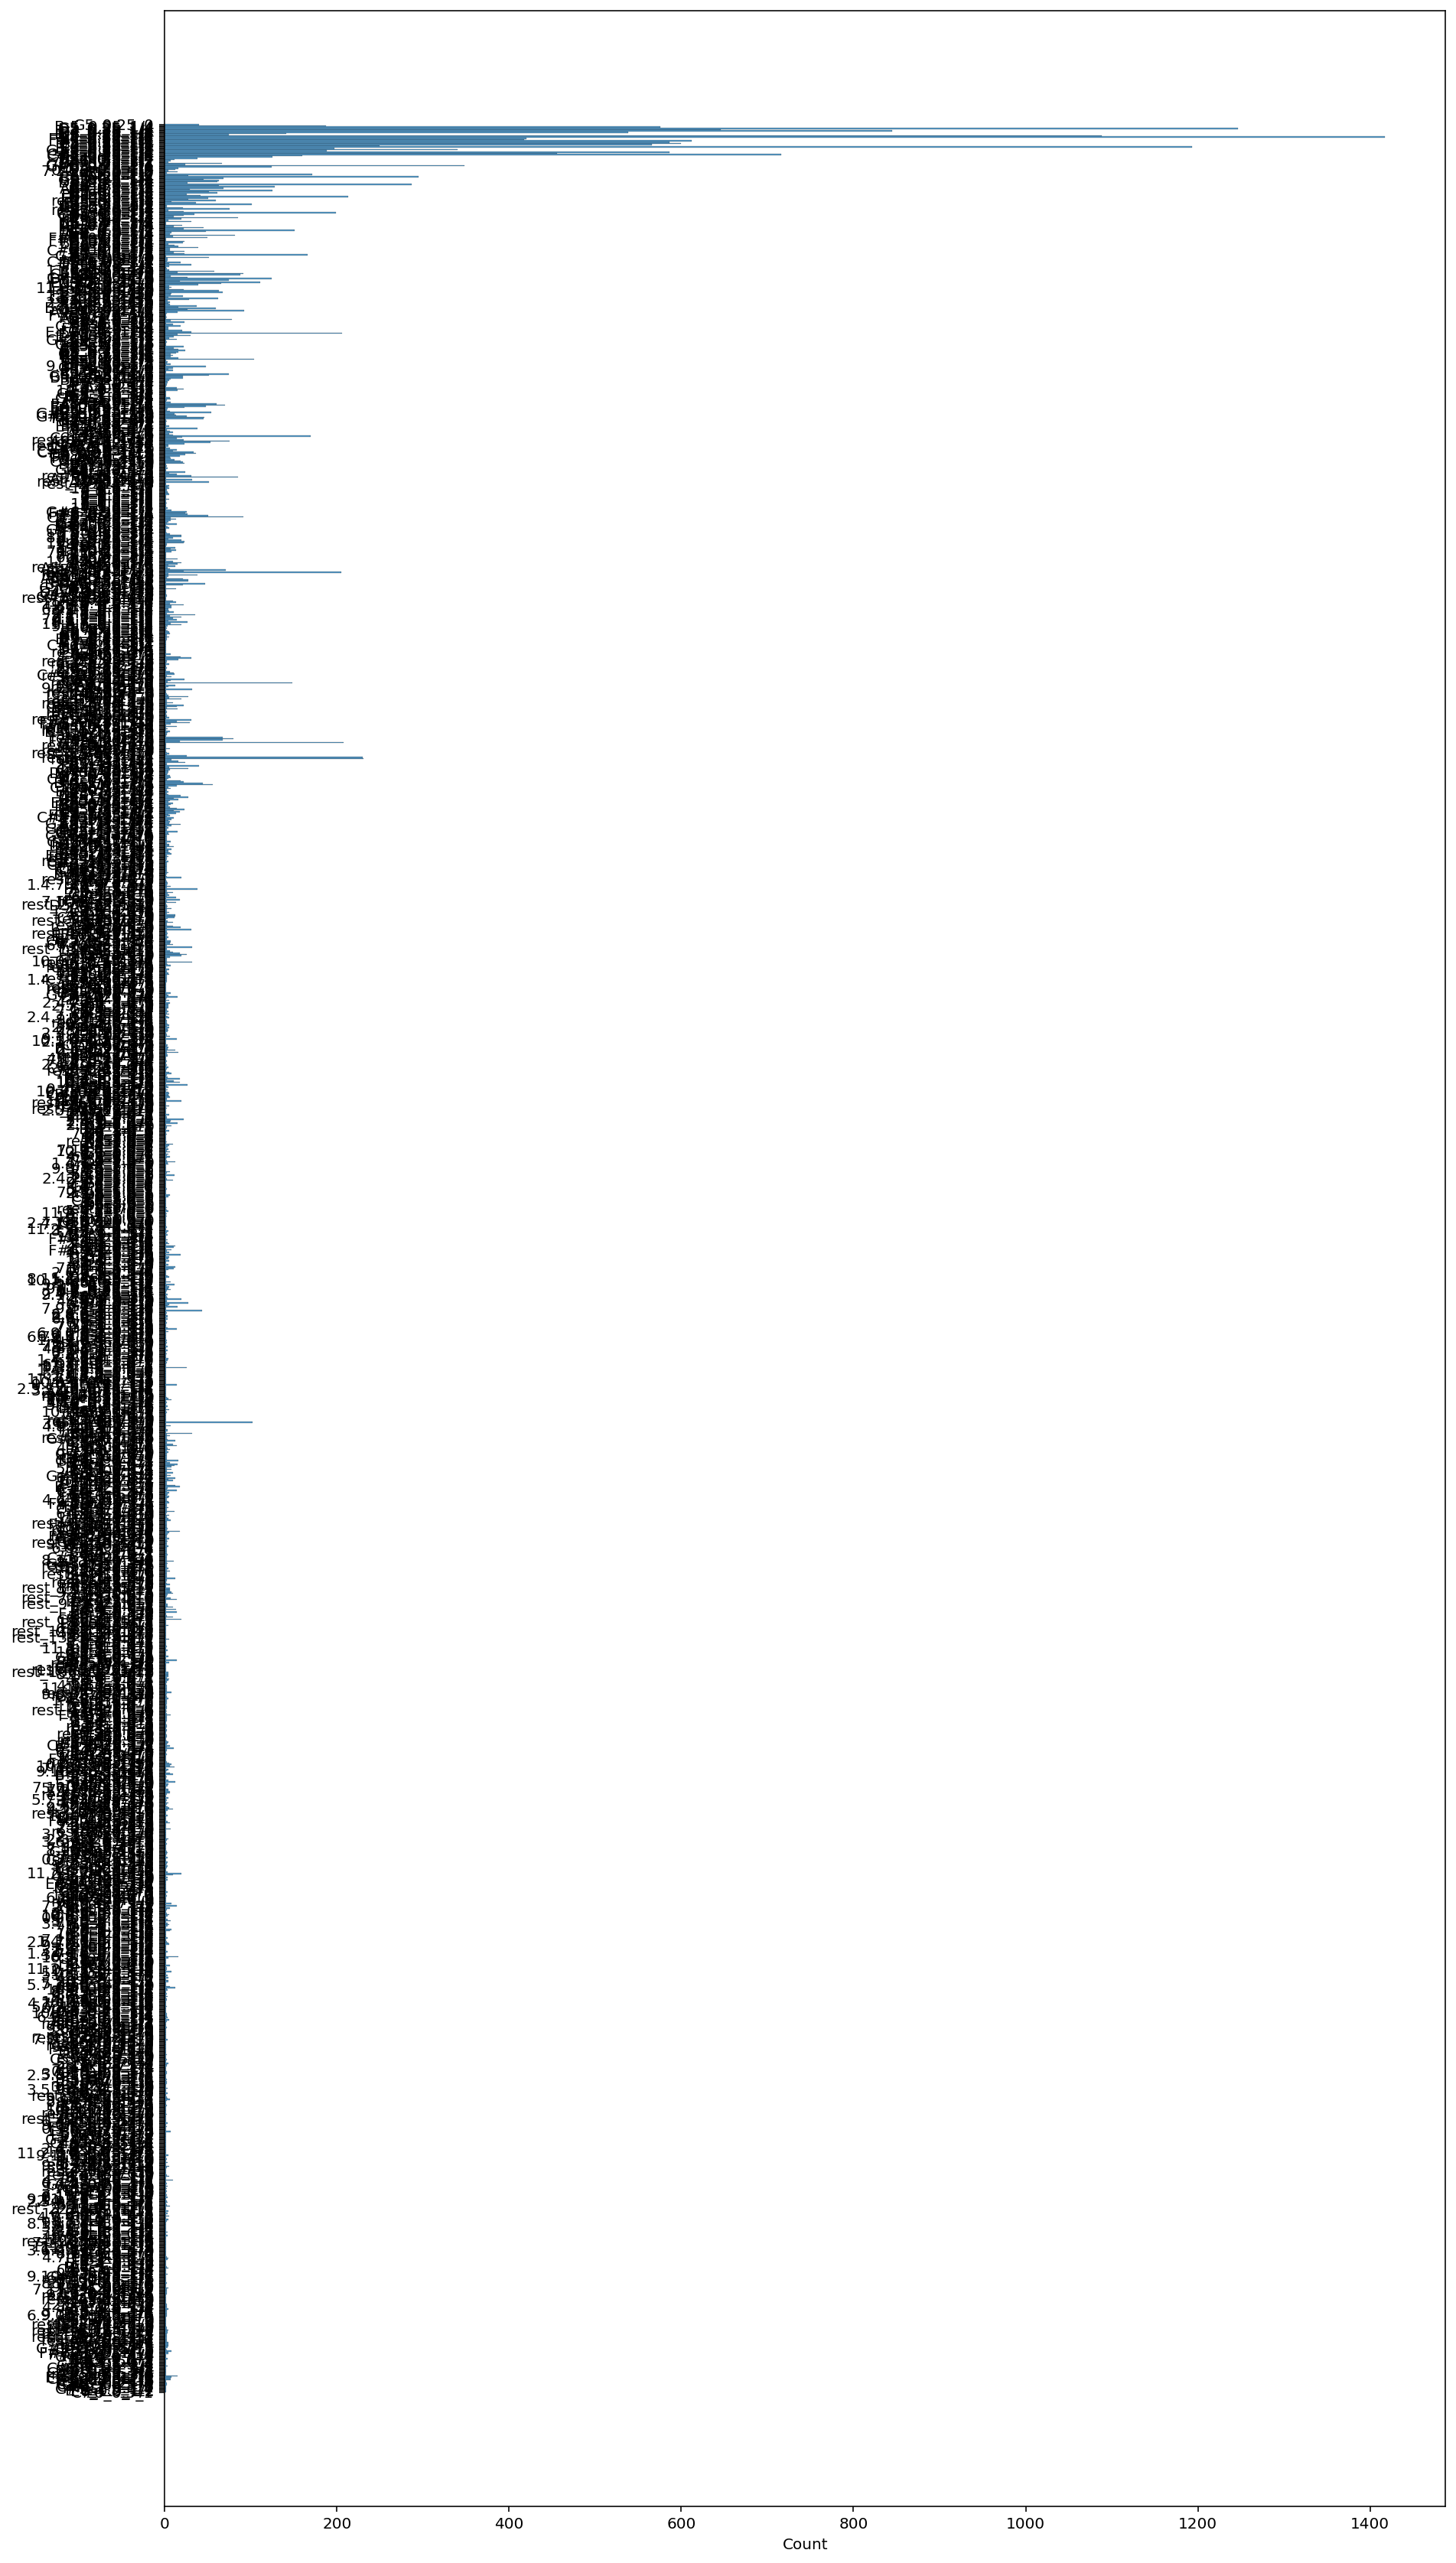

In [23]:
plt.figure(figsize=(15,30))
sns.histplot(y=all_tokens)

To prepare tokens for training we have to encode them as numbers. For this purpose we can create a dictionary which will map tokens to numbers and also numbers to tokens which will be used for predictions.

In [31]:
num_to_tokens = dict([i for i in enumerate(sorted(list(unique_tokens)))])
tokens_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_tokens)))])

In [172]:
pickle.dump(num_to_tokens, open('num_to_tokes.pkl', 'wb'))

In [32]:
tokens_full_map = [list(map(tokens_to_num.get, i)) for i in tokens_full]

In [34]:
tokens_full_map[0][:50]

[1525,
 854,
 1529,
 1111,
 1529,
 1111,
 830,
 1111,
 830,
 1504,
 830,
 1504,
 1081,
 1504,
 1081,
 813,
 1081,
 813,
 1488,
 813,
 1081,
 1504,
 830,
 1111,
 1529,
 1111,
 1037,
 830,
 744,
 1504,
 1307,
 1081,
 1307,
 744,
 1111,
 1332,
 774,
 1180,
 1111,
 1037,
 830,
 744,
 1504,
 1081,
 1504,
 830,
 1111,
 1529,
 854,
 1529]

The next step is to create a tf.dataset from mapped tokens. We gonna train the RNN model which will predict at each time step the next step. Therefore if we choose e.g. window of 100 points as features, then targets will also have 100 points shifted by 1 point. Dataset is created separately for each audio file and then they are concatenated, shuffled and batched. Additionally we split the dataset for train set and validation set in 80/20 ratio. 

In [35]:
def create_datasets(data, n_steps=100, batch_size=32, train_size=0.8):
    window_length = n_steps + 1
    datasets = []
    for j in [np.reshape(i, (-1, 1)) for i in data]:
        dataset = tf.data.Dataset.from_tensor_slices(j)
        dataset = dataset.window(window_length, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_length))
        datasets.append(dataset)
        
    dataset_final = datasets[0]
    for k in datasets[1:]:
        dataset_final = dataset_final.concatenate(k)

    dataset_final = dataset_final.shuffle(10000).batch(batch_size)
    dataset_final = dataset_final.map(lambda window: (window[:, :-1], window[:, 1:]))
    
    train_size_batch = int(train_size * len(list(dataset_final)))

    train_set = dataset_final.take(train_size_batch)
    val_set = dataset_final.skip(train_size_batch)
    
    return train_set, val_set

In [36]:
train_set, val_set = create_datasets(tokens_full_map)

In [37]:
len(list(train_set))

718

In [38]:
len(list(val_set))

180

In [39]:
for X, y in train_set.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 100, 1)


### Training

Our model is not a standard RNN with only recurrent layers but it is a combination of the Embedding layer with 1D convolutional layers and a single LSTM layer for capturing longer patterns. Last layer is a Dense layer with number of units equal to the number of unique tokens. Therefore for every time step we get the prediction as the vector of probabilities for each unique token. Model is fairly simple to train and after 15 epochs we get relatively high accuracy. Training can be done for longer to achieve even higher scores but possibly it will also require adding more recurrent layers. 

In [167]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(unique_tokens), output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(len(unique_tokens), activation="softmax")
])

checkpoint_cb = keras.callbacks.ModelCheckpoint('combined_full_gen.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 5)           9145      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          352       
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 32)          128       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 64)         

In [168]:
history = model.fit(train_set, epochs=15, validation_data=val_set, callbacks=[checkpoint_cb, early_stopping])

Epoch 1/15
718/718 [==============================] - 158s 215ms/step - loss: 3.9963 - accuracy: 0.1897 - val_loss: 2.1162 - val_accuracy: 0.4774
Epoch 2/15
718/718 [==============================] - 180s 249ms/step - loss: 1.4727 - accuracy: 0.6491 - val_loss: 0.7194 - val_accuracy: 0.8594
Epoch 3/15
718/718 [==============================] - 157s 218ms/step - loss: 0.6074 - accuracy: 0.8753 - val_loss: 0.4334 - val_accuracy: 0.9145
Epoch 4/15
718/718 [==============================] - 149s 206ms/step - loss: 0.3668 - accuracy: 0.9245 - val_loss: 0.3052 - val_accuracy: 0.9362
Epoch 5/15
718/718 [==============================] - 152s 210ms/step - loss: 0.2829 - accuracy: 0.9384 - val_loss: 0.2565 - val_accuracy: 0.9435
Epoch 6/15
718/718 [==============================] - 152s 211ms/step - loss: 0.2404 - accuracy: 0.9451 - val_loss: 0.2285 - val_accuracy: 0.9484
Epoch 7/15
718/718 [==============================] - 151s 209ms/step - loss: 0.2104 - accuracy: 0.9505 - val_loss: 0.2091 -

In [40]:
model_combined = keras.models.load_model('combined_full_gen.h5')

### Predictions

To make predictions we have to provide some starting points. They can be either taken randomly from validation set or generated as random integers within specified range. Also we can generate predictions based on the token which gives highest probability or choose tokens with their according probabilities. This can be controlled with an additional *temperature* parameter. If it is larger than 1.0, generated tokens are more random as the probabilities are closer together. For temperature smaller than 1.0 it is more conservative and picks tokens with highest probabilities. After getting predicted numbers we also have to map them back to the tokens. 

In [41]:
def gen_pred(n_steps=10, temperature_token=1.0):
    idx_0 = np.random.randint(0, len(list(val_set)))
    idx_1 = np.random.randint(0, 32)
    
    sample_tokens = np.array(list(val_set)[idx_0][0][idx_1, :5, :]).reshape(1, -1, 1)
   
#     sample_tokens = np.random.randint(0, len(unique_tokens), (1, 5, 1))

#     for step in range(n_steps):
#         pred_token = np.argmax(model_combined.predict(sample_tokens)[:, -1, :], axis=-1)
#         sample_tokens = np.concatenate([sample_tokens, pred_token.reshape(1, 1, 1)], axis=1)
    
    for step in range(n_steps):
        logits_tokens = model_combined.predict(sample_tokens)[:, -1, :]
        next_token = np.array(tf.random.categorical(tf.math.log(logits_tokens) / temperature_token, num_samples=1))[0].reshape(1, 1, 1)
        sample_tokens = np.concatenate([sample_tokens, next_token], axis=1)
    
    sample_tokens_mapped = list(map(num_to_tokens.get, list(sample_tokens.reshape(-1))))
    
    return sample_tokens_mapped

Now we have our predicted tokens and the last step is to convert them into notes, chords and rests and their respective durations and offsets. Each token has to be split into 3 parts which give symbol, duration and offset. Then we simply create a stream from a resulting list and save it as a *midi* file.

In [49]:
def gen_midi(pred):
    offset = Fraction(0.0)
    output_notes = []
    for pattern in pred:
        pattern_split = pattern.split('_')
        if ('.' in pattern_split[0]) or pattern_split[0].isdigit():
            offset += Fraction(pattern_split[2])
            notes_in_chord = pattern_split[0].split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            new_chord.duration = duration.Duration(Fraction(pattern_split[1]))
            output_notes.append(new_chord)
        elif pattern_split[0] == 'rest':
            offset += Fraction(pattern_split[2])
            new_note = note.Rest(pattern_split[0])
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(Fraction(pattern_split[1]))
            output_notes.append(new_note)
        else:
            offset += Fraction(pattern_split[2])
            new_note = note.Note(pattern_split[0])
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(Fraction(pattern_split[1]))
            output_notes.append(new_note)
              
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='gen_music.mid')
    midi_stream.show('midi')

In [50]:
preds = gen_pred(n_steps=20, temperature_token=1.1)
gen_midi(preds)

In [51]:
preds

['rest_41.5_0',
 'E5_0.25_1/4',
 'D5_0.25_1/4',
 'C5_0.25_1/4',
 'B-4_0.25_1/4',
 'A4_0.25_1/4',
 'B-4_0.25_1/4',
 'A4_0.25_1/4',
 'G4_0.25_1/4',
 'B-4_0.25_1/4',
 'D5_0.25_1/4',
 'F4_0.25_1/4',
 'E4_0.25_1/4',
 'F4_0.25_1/4',
 'C5_0.25_1/4',
 'B-4_0.25_1/4',
 'D5_0.25_1/4',
 'C5_0.25_1/4',
 'A4_0.25_1/4',
 'G#4_0.25_1/4',
 'A4_0.25_1/4',
 'D5_0.25_1/4',
 'F5_0.25_1/4',
 'A5_0.25_1/4',
 'A5_0.25_1/4']